In [27]:
# For finding pulse duration
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from qutip import *
from qutip.qip.operations import *
from qutip.qip.gates import *

from scipy.signal import argrelextrema

with open("rename.py") as f:
    exec(f.read())

In [28]:
# For simulation
from qutip.qip.operations.gates import *
import numpy as np
from NTU_sim import NTU_processor, NTU_simulation, NTU_compiler

import matplotlib.pyplot as plt
from qutip.solver import Options
options = Options(nsteps =10000)

# PH7013 Project

In this project, we want to simulate superconducting qubits to find the optimal control parameters to perform quantum gates.

<figure>
<img src="QHO.png" style="width:75%">
</figure>

Circuit diagram of a superconducting LC circuit and a superconducting qubit and their energy potentials. <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)


Superconducting qubits are derived from superconducting LC circuits, which are quantum harmonic oscillators, by replacing the inductor with a Josephon junction to form an anharmonic oscillator. The lowest two energy levels are then used as the basis states of the qubit.

## Superconducting Qubit XY Control

We use a voltage source to create microwave pulses to drive the qubit between |0> and |1>, the ground and excited states resperctively of the qubit.

From <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1), the driving Hamiltonian of a superconducting qubit can be approximated as

\begin{equation}
    \mathcal{H} = \Omega V_0 s(t) ( \cos{(\phi}) \sigma_x + \sin{(\phi)} \sigma_y )
\end{equation}

under the assumption that the qubit is driven at its resonant frequency, where $\Omega$ is the Rabi frequency of the qubit, $V_0$ is the amplitude of the pulse, $s(t)$ is the time-dependent shape of the pulse, $\phi$ is the phase of the pulse and $\sigma_x, \sigma_y$ are the Pauli matrices.

The instrument we use in the lab is the IcarusQ RFSoC <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) with a sampling rate of $5898.24$MS/s. For the qubit, we also use a typical Rabi frequency of $20$MHz.

We want to also investigate any potential impact of our instrument on the simulation. While driving microwave pulses at the qubit frequency, our instrument has a phase standard deviation of about $0.382$ degrees and an amplitude standard deviation that is about $0.01$. This is simulated from a normal distribution.

Both the phase and amplitude uncertainty of the instrument reduce the Rabi frequency, but in our case, it seems to be minimal. However, as seen in the driving Hamiltonian, the phase will also influence the axis of the rotation about the Bloch sphere.

In quantum computing, we are also concerned with the fidelity of the rotation. Hence, it may make more sense to measure the expectation values of the $x, y, z$ measurement operators.

From this, we now have a good model of how to compute the fidelity of the pulse and formulate a loss function for a gate. Next, we want to introduce the frequency drift component and pulse shaping to lower the pulse frequency bandwidth. A more complete qubit driving Hamiltonian that takes into account the detuning bet is as follows

\begin{equation}
    \mathcal{H} = \Omega V_0 s(t) ( (-I\cos{(\delta \omega t)} + Q\sin{(\delta \omega t)})\sigma_x + (I\sin{(\delta \omega t)}-Q\cos{(\delta \omega t)})\sigma_y)
\end{equation}

where $I = \cos{\phi}$, $Q=\sin{\phi}$ and $\delta \omega$ is the frequency detuning between the pulse frequency and the qubit frequency.

To get the frequency deviation of the qubit, we perform a Ramsey experiment on one of our qubits over 14 hours. A Ramsey experiment is when two $\pi$/2-pulses are sent to the qubit and a delay $\tau$ between the pulses is varied. The frequency of the Ramsey oscillation yields the frequency detuning between the driving frequency and the actual qubit frequency.

<figure>
<img src="14h_ramsey.png" style="width:100%">
</figure>

Ramsey fringes over 14 hours performed on the IQM chip, qubit 1.

<figure>
<img src="ramsey_drift.png" style="width:100%">
</figure>

Ramsey frequency extracted from the Ramsey fringes over 14 hours for IQM chip, qubit 1.

The standard deviation of the frequency for this qubit is $52.769$ MHz.

To decrease the frequency bandwidth of the driving pulse and avoid state leakage, we use a cosine-sum signal Hamming window, given by the following equation.

\begin{equation}
    s(t) = a_0 - (1 - a_0)\cos{(\frac{2\pi t}{T})}
\end{equation}

where $a_0 = 25/46$ for the Hamming window and $T$ is the length of the pulse.

In [29]:
# Parameters

VStd = 0.1
phaseStd = 0.382 / 180 * np.pi

detuningStd = 52769
samplingRate = 5898.24e6 # 5.89824 GS/s
omega = 20e6 # 20MHz

VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
phi = phiNaught + np.random.normal(scale=phaseStd)
I = np.cos(phi)
Q = np.sin(phi)

# Decoherence time
T1 = 8.66e-6*np.pi
T1_err = 0.49
T2 = 9.08e-6*np.pi
T2_err = 0.74e-6
T2_echo = 16.14e-6
T2_echo_err = 3.21e-6

## Finding pulse duration (not currently used in qutip)
Next, for quantum gates, we need the pulse time $t$ required to flip the qubit between $|0>$ and $|1>$. This pulse is known as the $\pi$-pulse. For this, we can use the interpolation function to search when we reach the $-1$ eigenvalue of $\sigma_z$.

In [30]:
def H_solver(t_0 = 0, t_final = 100e-9, init_state = basis(2,0), collapse_operators = [sigmaz()]):
    """
    Function to solve the given Hamiltonian for 1 qubit.
    Output: qutip result object
    """
    # Hamiltonian
    def H(t, args):
        dwt = np.random.normal(scale=detuningStd) * t
        s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / t_final)
        return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y()) 
    t_list = np.arange(t_0, t_final, 1/samplingRate)
    result = sesolve(H, init_state, t_list, collapse_operators,options=Options(nsteps=10000))
    return result

In [31]:
result_find_pulse = H_solver()

Text(0, 0.5, 'Expectation Value')

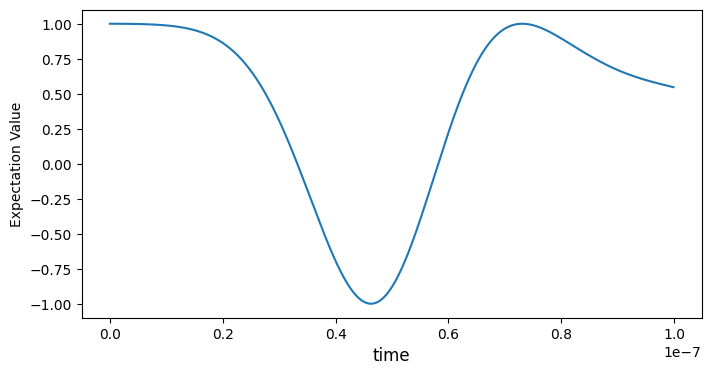

In [32]:
plot_expectation_values(result_find_pulse)
plt.xlabel("time")
plt.ylabel("Expectation Value")

Find the pi-pulse by optimizing

In [33]:
minimum_array = argrelextrema(result_find_pulse.expect[0], np.less)
first_min = minimum_array[0][0]
pi_pulse_duration = result_find_pulse.times[first_min]
pi_half_pulse_duration = pi_pulse_duration/2
print(pi_pulse_duration,pi_half_pulse_duration)

4.628499348958334e-08 2.314249674479167e-08


Solving the Hamiltonian

In [34]:
result = H_solver(
    t_final = pi_pulse_duration,
    collapse_operators = [sigmaz(),sigmax(),sigmay()]
    )

The plots are expectation value for $\sigma_z, \sigma_x,\sigma_y$ correspondingly.

Text(0, 0.5, 'Expectation Value')

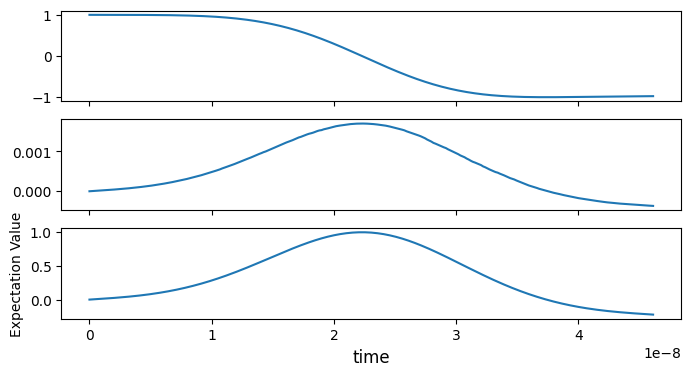

In [35]:
plot_expectation_values(result)
plt.xlabel("time")
plt.ylabel("Expectation Value")

In [36]:
np.savetxt('pulse_duration.txt',[pi_pulse_duration,pi_half_pulse_duration])

## Simulation and Randomized Benchmarking

Finally, we can start the RB protocol. Typically, we sweep the value of $N$ in the order of 50 to 100s of pulses. We also repeat the RB protocol for each value of $N$. 

In [44]:
param_dict ={"VNaught": VNaught, "VStd": VStd, "phaseStd":phaseStd,
            "omega": omega, "aNaught": aNaught, "detuningStd": detuningStd,
            "FPGA_noise_strength": VNaught * omega/2}

In [45]:
num_qubits = 1
num_gates_list = np.arange(5,105,20) # Number of Clifford gates added
num_samples = 5 # Number of runs to take average for each number of gate 

In [46]:
# Calling the NTU_simulation class
baseline = NTU_simulation(
    NTU_processor, NTU_compiler, num_qubits, param_dict, 
    add_FPGA_noise = False, t1 = None, t2 = None)
t1t2 = NTU_simulation(
    NTU_processor, NTU_compiler, num_qubits, param_dict, 
    add_FPGA_noise = False, t1 = T1, t2 = T2)
FPGA = NTU_simulation(
    NTU_processor, NTU_compiler, num_qubits, param_dict, 
    add_FPGA_noise = True, t1 = None, t2 = None)
FPGA_t1t2 = NTU_simulation(
    NTU_processor, NTU_compiler, num_qubits, param_dict, 
    add_FPGA_noise = True, t1 = T1, t2 = T2)

Gate set changed, pulse_coeff = 2.0016666666666665
Gate set changed, pulse_coeff = 2.0016666666666665
Gate set changed, pulse_coeff = 2.0016666666666665
Gate set changed, pulse_coeff = 2.0016666666666665


Gate set changed, pulse_coeff = 2.0016666666666665


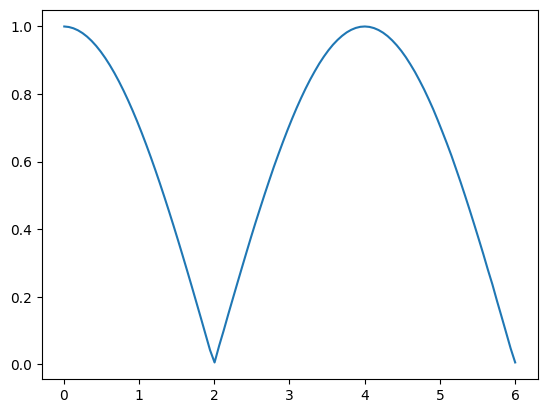

In [47]:
x=baseline.find_gates_set(plot_fidelity = True)

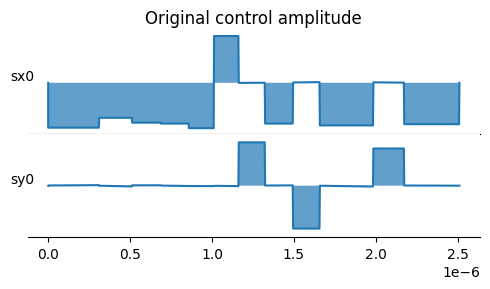

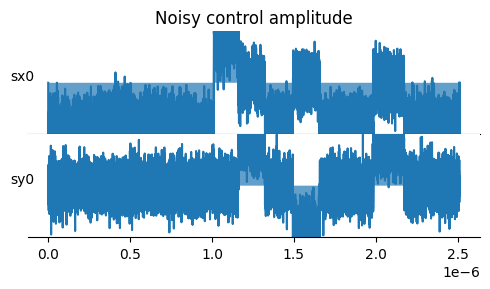

In [48]:
# Plotting the pulse with FPGA noise for a single simulation
# Note: currently not working for simulation without noise (eg: baseline)
y = FPGA.single_sim(10,True)

In [49]:
# Run the actual simulation
# Note: for num_gates_list = np.arange(5,105,20),num_samples = 5
# take 4 min
fidelity_baseline, error_baseline = baseline.test_run(num_samples, num_gates_list)
fidelity_t1t2, error_t1t2 = t1t2.test_run(num_samples, num_gates_list)
fidelity_FPGA, error_FPGA = FPGA.test_run(num_samples, num_gates_list)
fidelity_FPGA_t1t2, error_FPGA_t1t2 = FPGA_t1t2.test_run(num_samples, num_gates_list)

Text(0, 0.5, 'Ground State Fidelity')

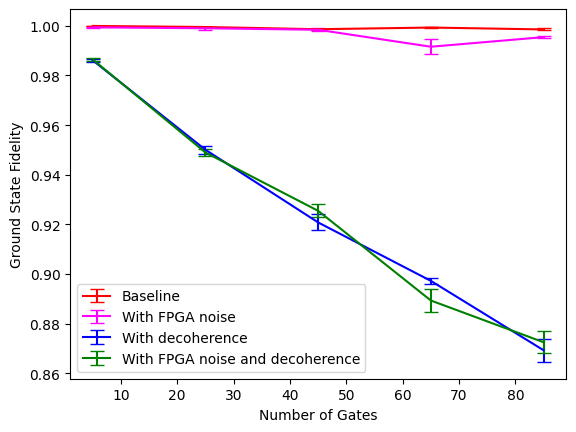

In [50]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_baseline, yerr=error_baseline, 
             color='red', capsize=5,label = 'Baseline')
plt.errorbar(num_gates_list, fidelity_FPGA, yerr=error_FPGA, 
             color='magenta', capsize=5, label = 'With FPGA noise')
plt.errorbar(num_gates_list, fidelity_t1t2, yerr=error_t1t2, 
             color='blue', capsize=5, label = 'With decoherence')
plt.errorbar(num_gates_list, fidelity_FPGA_t1t2, yerr=error_FPGA_t1t2, 
             color='green', capsize=5, label = 'With FPGA noise and decoherence')
plt.legend()
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")

## Fidelity and curve fitting (currently not used in qutip)

Next, we want to determine the gate fidelity. The ground state fidelity is determined by

\begin{equation}
    y = a + bp^x
\end{equation}

where $y$ is the ground state fidelity, $a, b$ capture the state preperation and measurement errors, $x$ is the number of Cliffords and $p$ captures the decay gradient. The error per clifford (EPC) is given by

\begin{equation}
    \epsilon_C = (1 - p) * 0.5
\end{equation}

As there are $1.875$ physical gates per Clifford, we then retrieve the approximate error per gate (EPG) as
\begin{equation}
    \epsilon_G = \frac{\epsilon_C}{1.875}
\end{equation}

The gate fidelity is then defined as
\begin{equation}
    \mathcal{F} = 1 - \epsilon_G
\end{equation}

As we increase the number of gates, we expect the errors from the phase and amplitude uncertainties to accumulate. However, in this case, we did not include the effect of decoherence on the qubit. To do so, we would have to work with density matrices and unitaries instead.

The Bloch-Redfield density matrix is defined as
\begin{equation}
    \rho_{BR} = \begin{bmatrix} 1 + (|\alpha|^2 -1)e^{-\Gamma_1 t} & \alpha\beta^* e^{i\delta \omega t} e^{-\Gamma_2 t} \\ \alpha^*\beta e^{i\delta \omega t} e^{-\Gamma_2 t} & |\beta|^2e^{-\Gamma_1 t} \end{bmatrix}
\end{equation}
where $\alpha, \beta$ are the probabilitiy amplitudes of the initial state, $\Gamma_1$ describes the longitudinal relaxation or fluorescence and $\Gamma_2$ describes the transverse relaxation. However, this is outside the scope of the project.

In conclusion, we have demonstrated how to simulate superconducting qubit control, include pulse shaping and demonstrated ths control on a RB experiment.